In [44]:
# Utilities
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, GlobalAveragePooling2D, MaxPool2D,Flatten
from keras.applications import ResNet50
from keras.optimizers import Adamax
from keras import metrics
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator

In [35]:
from google.colab import drive
drive.mount('/content/drive')

# Veri yollarını belirtin
data_dir = "/content/drive/My Drive/kaan-oral_cancer/Oral_cancer_histopathological_images"  # Veri klasörünün kök dizini
class_names = ["0", "1"]  # Sınıf adları

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [36]:
import os

# Sınıf adları
class_names = ["0", "1"]

# Toplam etiket ve resim sayıları
total_labels = 0
total_images = 0

# Her sınıf için etiket ve resim sayılarını hesapla
for class_name in class_names:
    class_dir = os.path.join(data_dir, class_name)
    class_labels = len(os.listdir(class_dir))
    class_images = len([f for f in os.listdir(class_dir) if f.endswith('.png')])  # .png uzantılı dosyaları say

    total_labels += class_labels
    total_images += class_images

    print(f"Sınıf: {class_name}, Etiket Sayısı: {class_labels}, Resim Sayısı: {class_images}")

# Toplam etiket ve resim sayılarını yazdır
print(f"\nToplam Etiket Sayısı: {total_labels}")
print(f"Toplam Resim Sayısı: {total_images}")


Sınıf: 0, Etiket Sayısı: 146, Resim Sayısı: 146
Sınıf: 1, Etiket Sayısı: 91, Resim Sayısı: 91

Toplam Etiket Sayısı: 237
Toplam Resim Sayısı: 237


In [37]:
# Data and Labels Collection
data = []
labels = []

for class_name in class_names:
    class_dir = os.path.join(data_dir, class_name)
    for img_name in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_name)
        img = cv2.imread(img_path)
        data.append(cv2.resize(img, (64, 64)))
        labels.append(class_name)


In [38]:

# Convert to NumPy arrays
data = np.array(data)
labels = np.array(labels)

# Split data into training and testing sets
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, random_state=42)

train_labels = train_labels.astype(int)
test_labels = test_labels.astype(int)

from keras.utils import to_categorical

# Convert training labels to one-hot encoding
train_labels_onehot = to_categorical(train_labels, num_classes=2)

# Convert testing labels to one-hot encoding
test_labels_onehot = to_categorical(test_labels, num_classes=2)

In [17]:
train_data_scaled = train_data / 255.0
test_data_scaled = test_data / 255.0

In [52]:
# ResNet-50 Model
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

# Freeze layers
#for layer in resnet_model.layers:
#    layer.trainable = False

# Build Model
model = Sequential()
model.add(resnet_model)
model.add(MaxPool2D())
model.add(Flatten())
model.add(Dense(units=256, activation='sigmoid'))
model.add(Dense(units=2, activation='sigmoid'))

In [53]:
# Compile Model
model.compile(optimizer=Adamax(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

checkpoint = ModelCheckpoint("best_model_resneet_weights.h5",
                             monitor='val_acc',  # Kaydetme kriteri olarak doğruluk metriğini kullanın
                             verbose=1,
                             save_best_only=True,    # Sadece en iyi performansı gösteren ağırlıkları kaydedin
                             mode='max')

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_acc', patience=3, mode='auto', factor=0.3, min_lr=0.000001)
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

# Train Model
history = model.fit(train_data, train_labels_onehot, epochs=100, validation_split=0.2, callbacks=[reduce_lr, early_stopping, checkpoint])


Epoch 1/100
5/5 [==============================] - ETA: 0s - loss: 0.6347 - accuracy: 0.6689

5/5 [==============================] - 25s 375ms/step - loss: 0.6347 - accuracy: 0.6689 - val_loss: 0.7272 - val_accuracy: 0.6579 - lr: 0.0010
Epoch 2/100
5/5 [==============================] - ETA: 0s - loss: 0.1629 - accuracy: 0.9536

5/5 [==============================] - 0s 51ms/step - loss: 0.1629 - accuracy: 0.9536 - val_loss: 0.9128 - val_accuracy: 0.6316 - lr: 0.0010
Epoch 3/100
5/5 [==============================] - ETA: 0s - loss: 0.0451 - accuracy: 1.0000

5/5 [==============================] - 0s 50ms/step - loss: 0.0451 - accuracy: 1.0000 - val_loss: 0.9389 - val_accuracy: 0.6842 - lr: 0.0010
Epoch 4/100
5/5 [==============================] - ETA: 0s - loss: 0.0170 - accuracy: 1.0000

5/5 [==============================] - 0s 53ms/step - loss: 0.0170 - accuracy: 1.0000 - val_loss: 0.8986 - val_accuracy: 0.6579 - lr: 0.0010
Epoch 5/100
5/5 [==============================] - ETA: 0s - loss: 0.0108 - accuracy: 1.0000

5/5 [==============================] - 0s 52ms/step - loss: 0.0108 - accuracy: 1.0000 - val_loss: 0.7301 - val_accuracy: 0.7105 - lr: 0.0010
Epoch 6/100
5/5 [==============================] - ETA: 0s - loss: 0.0089 - accuracy: 1.0000

5/5 [==============================] - 0s 49ms/step - loss: 0.0089 - accuracy: 1.0000 - val_loss: 0.8757 - val_accuracy: 0.7632 - lr: 0.0010
Epoch 7/100
5/5 [==============================] - ETA: 0s - loss: 0.0054 - accuracy: 1.0000

5/5 [==============================] - 0s 45ms/step - loss: 0.0054 - accuracy: 1.0000 - val_loss: 1.0032 - val_accuracy: 0.7368 - lr: 0.0010
Epoch 8/100
5/5 [==============================] - ETA: 0s - loss: 0.0063 - accuracy: 1.0000

5/5 [==============================] - 0s 85ms/step - loss: 0.0063 - accuracy: 1.0000 - val_loss: 1.1270 - val_accuracy: 0.7368 - lr: 0.0010


In [ ]:
# En iyi ağırlıkları yükleme
model.load_weights('best_model_resneet_weights.h5')

In [54]:
# Model Evaluation
evaluation = model.evaluate(test_data , test_labels_onehot)
test_accuracy = evaluation[1]
print("Test accuracy:", test_accuracy)


2/2 [==============================] - 0s 10ms/step - loss: 0.8379 - accuracy: 0.7500
Test accuracy: 0.75


2/2 [==============================] - 1s 9ms/step


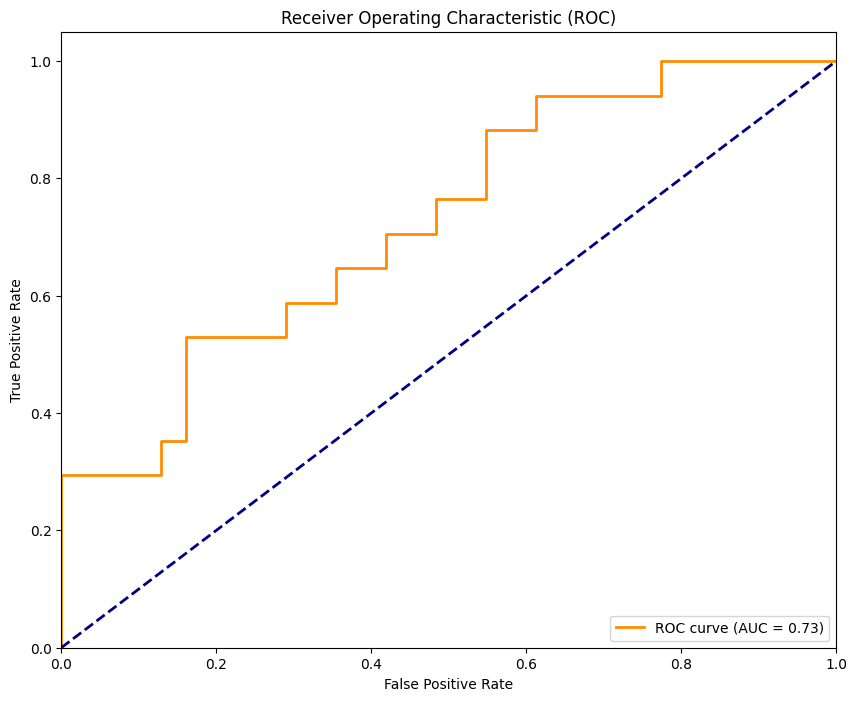

In [55]:

# ROC Curve and AUC
predicted_probabilities = model.predict(test_data)
true_labels_positive = test_labels_onehot[:, 1]
fpr, tpr, thresholds = roc_curve(true_labels_positive, predicted_probabilities[:, 1])
roc_auc = auc(fpr, tpr)
# ROC Curve Plot
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


In [11]:
from sklearn.metrics import confusion_matrix

predictions = model.predict(test_data_scaled)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(test_labels_onehot, axis=1)

cm = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:")
print(cm)

2/2 [==============================] - 0s 8ms/step
Confusion Matrix:
[[31  0]
 [17  0]]


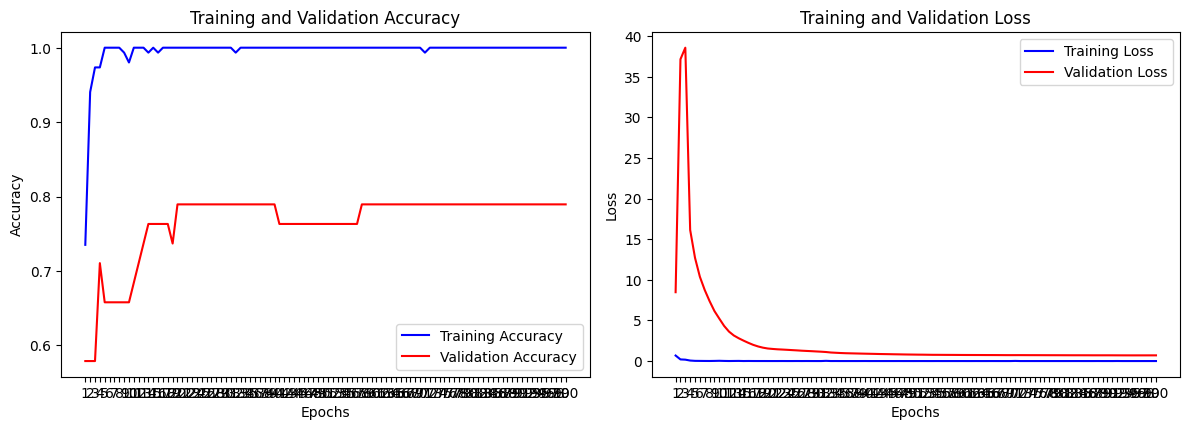

In [ ]:
# Extracting training history
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_accuracy) + 1)

plt.figure(figsize=(12, 8))

# Accuracy plot
plt.subplot(2, 2, 1)
plt.plot(epochs, train_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.xticks(epochs)  # Set the x-axis ticks explicitly

# Loss plot
plt.subplot(2, 2, 2)
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.xticks(epochs)  # Set the x-axis ticks explicitly

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import classification_report

predictions = model.predict(test_data_scaled)

predicted_labels = np.argmax(predictions, axis=1)

true_labels = np.argmax(test_labels_onehot, axis=1)

class_report = classification_report(true_labels, predicted_labels)

# Print the classification report
print("Classification Report:")
print(class_report)


2/2 [==============================] - 0s 66ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.71      0.77        31
           1       0.59      0.76      0.67        17

    accuracy                           0.73        48
   macro avg       0.72      0.74      0.72        48
weighted avg       0.76      0.73      0.73        48



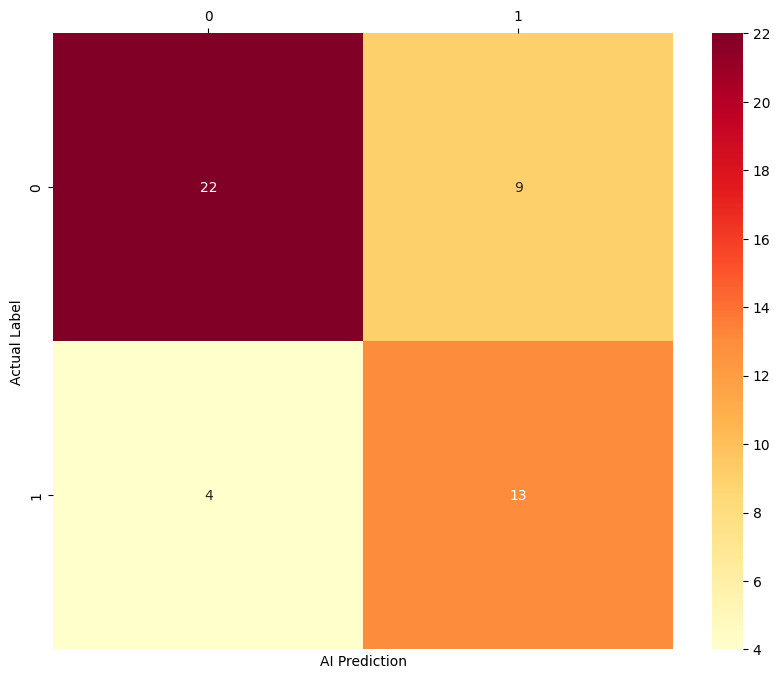

In [ ]:
# Karışıklık matrisini görselleştir
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
hm = sns.heatmap(cm, annot=True, fmt="d", cmap="YlOrRd", xticklabels=class_names, yticklabels=class_names)
hm.tick_params(labeltop=True, labelbottom=False, top=True, bottom=False)
plt.xlabel('AI Prediction')
plt.ylabel('Actual Label')
plt.show()